In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kern
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.optimize import bisect, curve_fit

PARENT_DIR = r'D:\projects\diverters\src'
CURR_DIR = os.path.join(PARENT_DIR, 'analysis_v1')
sys.path.append(PARENT_DIR)

from materials.iter import eval_limits

In [3]:
def make_grid(_min_x, _max_x, _min_y, _max_y, _n, x_label='x', y_label='y'):
    _lin_x = np.linspace(_min_x, _max_x, _n)
    _lin_y = np.linspace(_min_y, _max_y, _n)
    _xv, _yv = np.meshgrid(_lin_x, _lin_y)

    return pd.DataFrame({x_label: _xv.ravel(), y_label: _yv.ravel()})


def plot_np(_df, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(_df.iloc[:, 0], _df.iloc[:, 1], _df.iloc[:, 2])

    col_names = _df.columns.tolist()
    ax.set_xlabel(col_names[0])
    ax.set_ylabel(col_names[1])
    ax.set_zlabel(col_names[2], labelpad=-2)

    if title:
        ax.set_title(title)

    plt.subplots_adjust(left=0.0, right=1.20, bottom=0.0, top=1.20)

    plt.show()

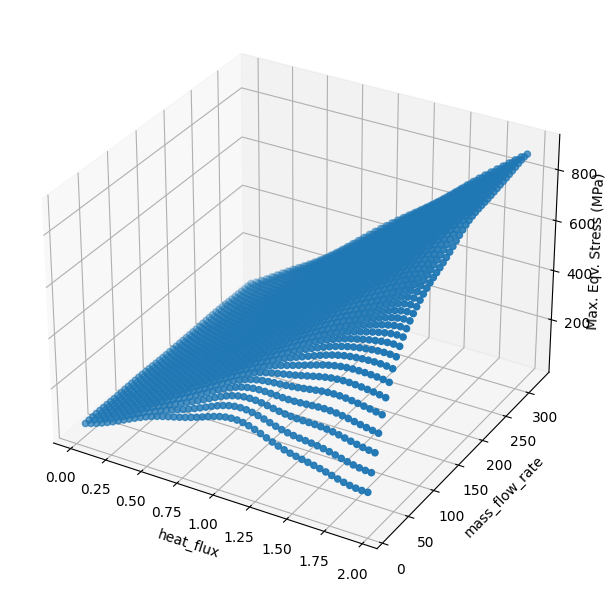

RMSE Validation: [-12.81029816 -15.22605426 -12.67892321]
Mean RMSE = -13.5717585412088


In [4]:
def make_gpr(_x_train, _y_train):
    inp_kernel = kern.RBF(length_scale=10)
    _gpr = GaussianProcessRegressor(
        kernel=inp_kernel,
        n_restarts_optimizer=100
    )
    _scaler = StandardScaler()
    _x_train_scaled = _scaler.fit_transform(_x_train.values, y=_y_train.values)
    _gpr.fit(_x_train_scaled, _y_train)

    return _gpr, _scaler


def plot_gpr(_x_train, _gpr, _scaler, y_label='result'):
    _grid = make_grid(
        _x_train.iloc[:, 0].min(),
        _x_train.iloc[:, 0].max(),
        _x_train.iloc[:, 1].min(),
        _x_train.iloc[:, 1].max(),
        50,
        x_label=_x_train.columns[0],
        y_label=_x_train.columns[1]
    )
    _grid[y_label] = _gpr.predict(_scaler.transform(_grid.values))
    plot_np(_grid)


def score_gpr(_x_train, _y_train, _gpr, _scaler):
    _x_train_scaled = _scaler.fit_transform(_x_train.values)

    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
    results = cross_val_score(_gpr, _x_train_scaled, _y_train, cv=3, scoring=rmse_scorer)
    print("RMSE Validation:", results)
    print("Mean RMSE =", results.mean())


def perform_gpr_analysis(_x_train, _y_train, y_label='result'):
    _gpr, _scaler = make_gpr(_x_train, _y_train)

    plot_gpr(_x_train, _gpr, _scaler, y_label=y_label)
    score_gpr(_x_train, _y_train, _gpr, _scaler)

    return _gpr, _scaler

df = pd.read_csv(os.path.join(CURR_DIR, 'results.frame'), index_col=0)

X_train = df[['heat_flux', 'mass_flow_rate']]
Y_train = df['max_eqv_stress']

gpr_eqv_stress, scaler_eqv_stress = perform_gpr_analysis(X_train, Y_train, y_label='Max. Eqv. Stress (MPa)')

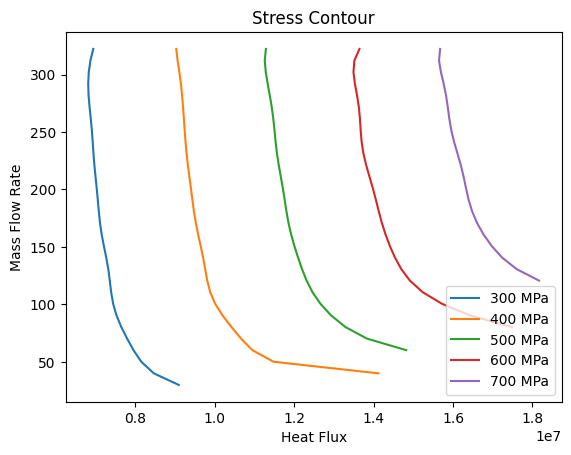

In [5]:
def predict(heat_flux, mass_flow_rate, offset, _gpr, _scaler):
    scaled = _scaler.transform([[heat_flux, mass_flow_rate]])
    return _gpr.predict(scaled)[0] - offset


def contour(stress_lim, _gpr, _scaler):
    heat_min = df['heat_flux'].min()
    heat_max = df['heat_flux'].max()

    pts = []

    for mass_flow in np.linspace(30, df['mass_flow_rate'].max(), 30):
        curr_heat_min = heat_min

        while True:
            f_min = predict(curr_heat_min, mass_flow, stress_lim, _gpr, _scaler)
            for heat_trial in np.linspace(curr_heat_min, heat_max, 30):
                f_val = predict(heat_trial, mass_flow, stress_lim, _gpr, _scaler)
                if f_min * f_val < 0:
                    curr_heat_max = heat_trial
                    break
            else:
                break

            heat_val = bisect(predict, curr_heat_min, curr_heat_max, args=(mass_flow, stress_lim, _gpr, _scaler), maxiter=100)
            pts.append((heat_val, mass_flow))

            curr_heat_min = curr_heat_max

    return np.array(pts)


fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Stress Contour")
ax.set_xlabel("Heat Flux")
ax.set_ylabel("Mass Flow Rate")

for lim in [300, 400, 500, 600, 700]:
    contour_pts = contour(lim, gpr_eqv_stress, scaler_eqv_stress)
    ax.plot(contour_pts[:, 0], contour_pts[:, 1], label=f"{lim} MPa")

ax.legend()

In [6]:
elastic_mod = 3.33e5
ult_strength = 6.5098e2
yield_strength = 4.323e2
uniform_elong = 0.001298198

limits = eval_limits(yield_strength, ult_strength, uniform_elong, elastic_mod)

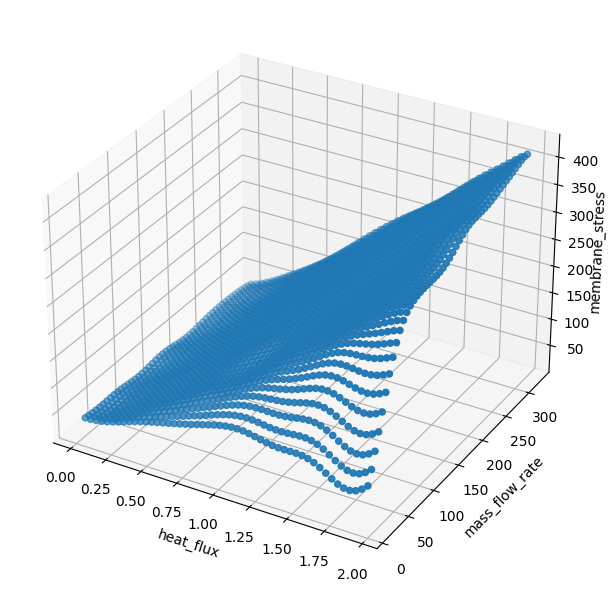

RMSE Validation: [-10.77436223  -8.92712548  -6.75647038]
Mean RMSE = -8.819319362061481


D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


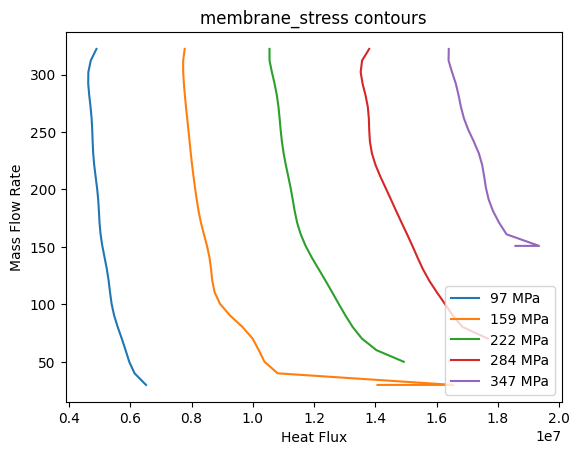

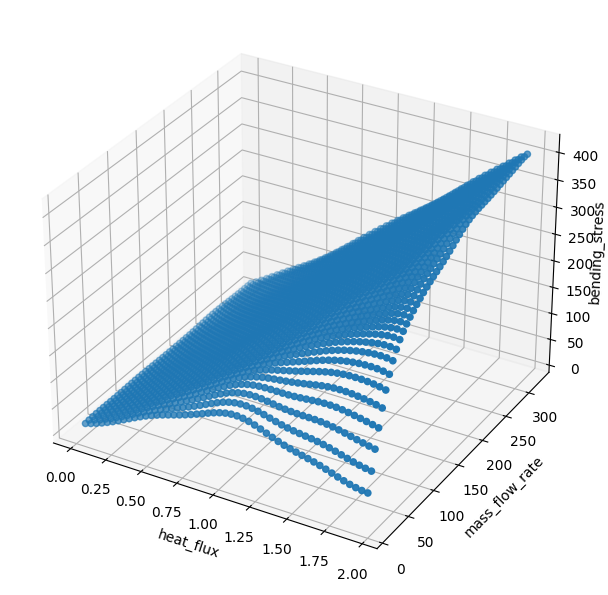

RMSE Validation: [-6.88707929 -7.20015823 -7.51191794]
Mean RMSE = -7.199718487446879


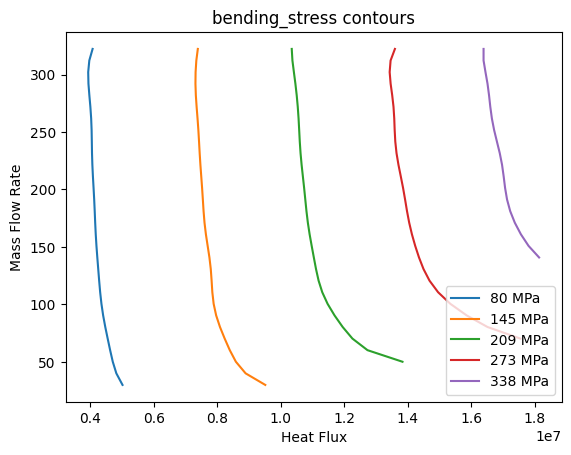

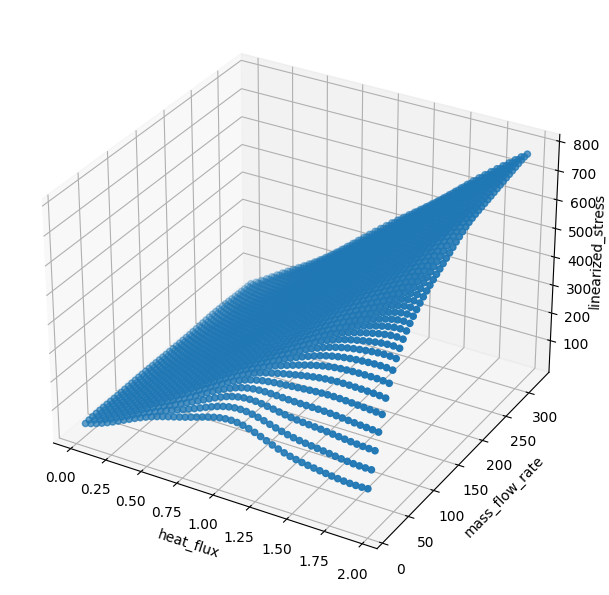

D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RMSE Validation: [-13.31405205 -12.75313947  -9.83996391]
Mean RMSE = -11.969051808966986


D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


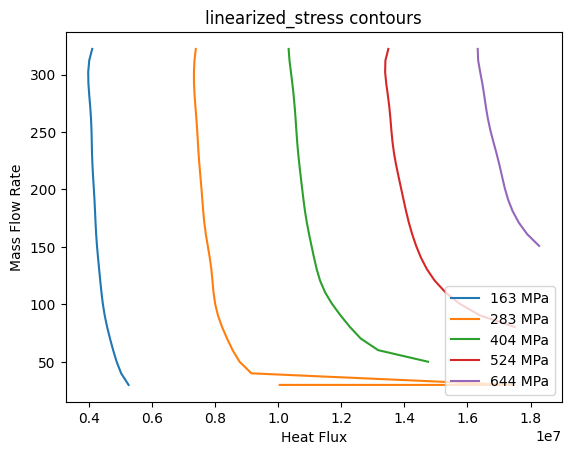

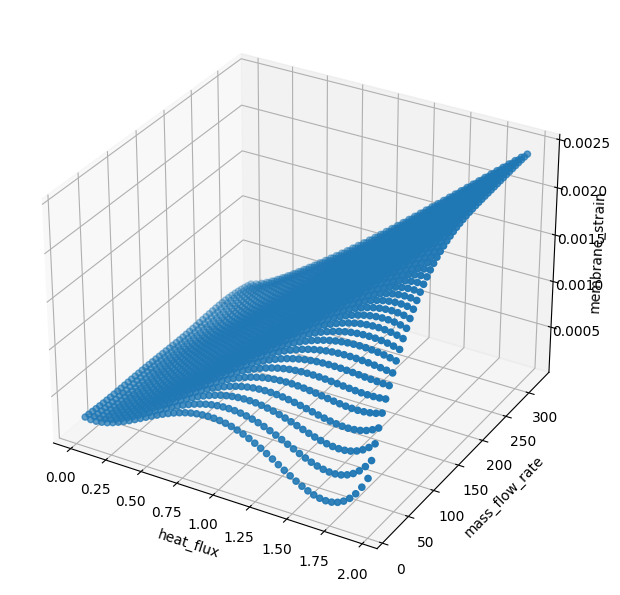

D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

RMSE Validation: [-3.96446521e-05 -1.89829652e-05 -1.17526207e-04]
Mean RMSE = -5.8717941461822124e-05


D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


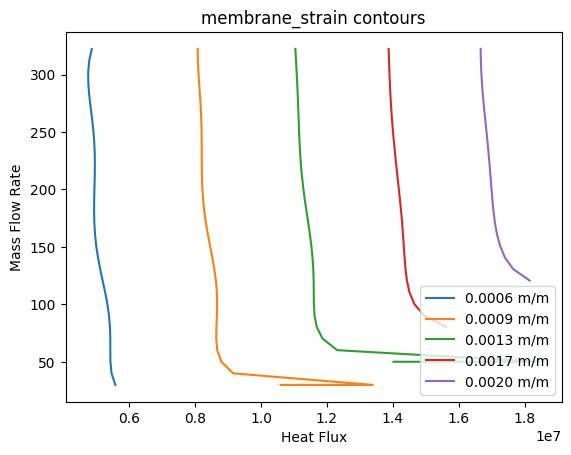

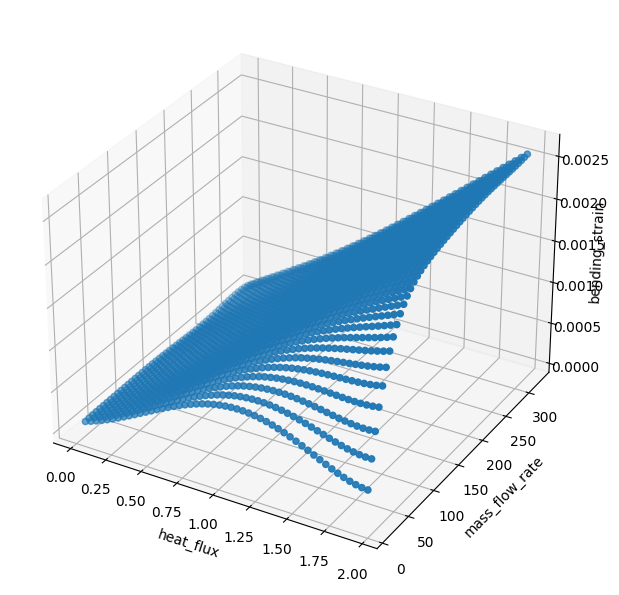

D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

RMSE Validation: [-4.60621406e-05 -1.63314544e-05 -2.50622208e-05]
Mean RMSE = -2.915193862018989e-05


D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


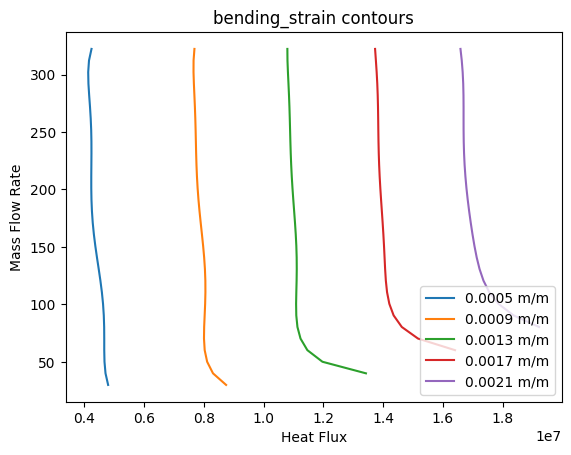

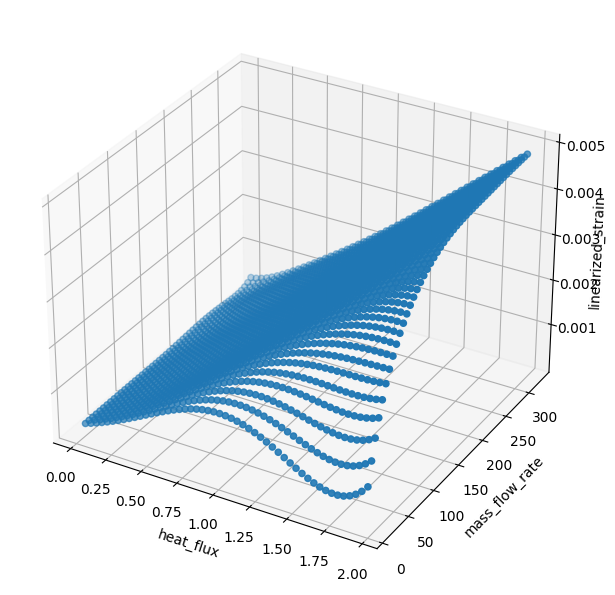

D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\projects\diverters\src\venv\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

RMSE Validation: [-6.79305983e-05 -1.62248048e-05 -1.20429251e-04]
Mean RMSE = -6.81948846641881e-05


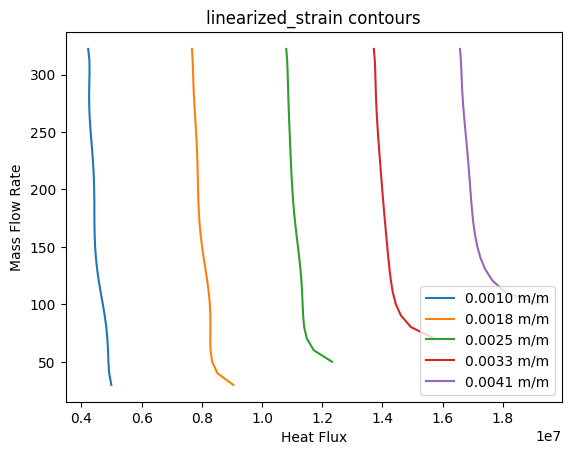

In [7]:
X_train = df[['heat_flux', 'mass_flow_rate']]
MODES = [
    'membrane_stress',
    'bending_stress',
    'linearized_stress',
    'membrane_strain',
    'bending_strain',
    'linearized_strain'
]

contour_results = {}

for mode in MODES:
    curr_gpr, curr_scaler = perform_gpr_analysis(X_train, df[mode], y_label=mode)

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(f"{mode} contours")
    ax.set_xlabel("Heat Flux")
    ax.set_ylabel("Mass Flow Rate")

    for lim in np.linspace(df[mode].min(), df[mode].max(), 7)[1:-1]:
        contour_results[mode] = contour(lim, curr_gpr, curr_scaler)
        curr_label = f"{lim:.0f} MPa" if 'stress' in mode else f"{lim:.4f} m/m"
        ax.plot(contour_results[mode][:, 0], contour_results[mode][:, 1], label=curr_label)

    ax.legend()
